# Deep Learning for Weather Forecasting 

## Objective of this notebook

The goal of this notebook is to demonstrate how deep learning models can be used
to perform **spatio-temporal forecasting of meteorological variables**.

We focus on the prediction of future weather fields from past observations,
which is a central problem in modern numerical weather prediction and climate science.

This demo illustrates, on a simplified dataset, the core ideas discussed in:
[Pangu-Weather: A 3D High-Resolution System for Fast and Accurate Global Weather Forecast](https://arxiv.org/pdf/2211.02556)

In particular, we explore how neural networks can:
- exploit **spatial correlations** (weather maps),
- model **temporal dynamics** (evolution over time),
- and outperform simple baselines such as persistence models.

## Installation and import

In [1]:
# Install required packages if necessary

# !pip install numpy xarray netCDF4 matplotlib cartopy torch torchvision tqdm

In [2]:
# Import necessary libraries
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# Use MPS if available, otherwise fall back to CUDA or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)

Device: mps


In [4]:
# The dataset provides sequences of meteorological fields.
# Each sample is composed of:
# - an input sequence of past time steps (x)
# - a target sequence of future time steps to predict (y)

url = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2023.nc"
ds = xr.open_dataset(url)
ds

<xarray.Dataset> Size: 15MB
Dimensions:    (time: 365, nbnds: 2, lat: 73, lon: 144)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 6kB ...
    air        (time, lat, lon) float32 15MB ...
Attributes:
    Conventions:                     COARDS
    title:                           mean daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    References:                      http://www.esrl.noaa.gov/psd/data/gridde...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

## Spatio-temporal forecasting setup

We frame weather forecasting as a **supervised learning problem**.

Given a sequence of past weather fields: $X = (x_{t-seq\_len+1}, \dots, x_t)$


the model must predict the future fields: $Y = (x_{t+1}, \dots, x_{t+pred\_len})$

This formulation follows the standard approach in deep learning-based
weather forecasting and is consistent with the methodology described in the article.


In [5]:
temp = ds["air"]  # shape (time, lat, lon)
print(temp.shape)

# Apply geographical subsetting for Europe
lon_min, lon_max = -10, 40
lat_min, lat_max = 35, 70
temp_europe = temp.sel(
    lon=slice(lon_min, lon_max),
    lat=slice(lat_max, lat_min)  # selon l'ordre de lat dans le dataset
)
print(temp_europe.shape)

(365, 73, 144)
(365, 15, 17)


In [6]:
# Normalize the data
mean = temp_europe.mean().item()
std = temp_europe.std().item()
temp_norm = (temp_europe - mean) / std
data = temp_norm.values  # (T, H, W)

In [7]:
# seq_len defines how many past time steps are used as input
# pred_len defines how many future time steps the model must predict
seq_len = 30
pred_len = 30

class MultiStepWeatherDataset(Dataset):
    def __init__(self, data, seq_len=seq_len, pred_len=pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]           # input sequence
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len]  # target sequence
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = MultiStepWeatherDataset(data, seq_len=seq_len, pred_len=pred_len)

# shuffle=True means that sequences are sampled randomly during training.
# This improves statistical learning but breaks the chronological order.
# However, the temporal structure is still preserved within each sequence so the model still learns temporal dependencies.
loader = DataLoader(dataset, batch_size=8, shuffle=True)


## Why convolutional recurrent networks?

Weather data are inherently **spatio-temporal**:
- nearby locations influence each other (spatial coherence),
- atmospheric dynamics evolve continuously over time.

Convolutional recurrent architectures allow us to:
- preserve spatial structure (unlike fully-connected networks),
- explicitly model temporal dependencies (unlike static CNNs).

This architectural choice is aligned with the ideas presented in the article.

<div class="alert-success">

### **ConvLSTM (Convolutional Long Short-Term Memory)**

ConvLSTM is a neural network architecture specifically designed to model **spatio-temporal data**, i.e. data that exhibit both spatial structure
and temporal dynamics, such as video sequences or meteorological fields.

The architecture was introduced by **Shi et al. (2015)** in the paper [Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting](https://arxiv.org/abs/1506.04214)


### What is ConvLSTM?

ConvLSTM is an extension of the classical LSTM recurrent neural network. In a standard LSTM, inputs and hidden states are treated as vectors and
combined using fully connected (linear) layers.

In ConvLSTM, these linear transformations are replaced by **convolutional operations**.
As a result:
- inputs, hidden states, and cell states are **2D or 3D tensors** (e.g. weather maps),
- temporal dependencies are modeled through the LSTM recurrence,
- spatial correlations are preserved through convolutions.

The ConvLSTM cell still relies on the same gating mechanism as LSTM (input gate, forget gate, output gate), but each gate is implemented
using convolutional kernels instead of dense matrices.


### Why is ConvLSTM well-suited for weather data?

Meteorological data naturally exhibit:
- **spatial coherence** (fronts, pressure systems, smooth gradients),
- **temporal continuity** (slow evolution governed by physical dynamics).

ConvLSTM introduces an inductive bias that explicitly reflects these properties: it learns how **spatial structures evolve over time**, rather than treating each grid point independently.

This makes ConvLSTM particularly suitable for:
- precipitation nowcasting,
- short- to medium-range weather forecasting,
- spatio-temporal prediction on regular grids.


In [8]:
class ConvLSTMCell(nn.Module):
    """
    This model combines:
    - convolutional layers to extract spatial features
    - recurrent dynamics to model temporal evolution
    """
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, hidden_dim*4, kernel_size, padding=padding)

    def forward(self, x, h_prev, c_prev):
        # The model processes spatial information at each time step
        # and propagates temporal information through hidden states
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

class ConvLSTM(nn.Module):
    def __init__(self, seq_len=4, pred_len=5, input_dim=1, hidden_dim=32):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.hidden_dim = hidden_dim
        self.cell = ConvLSTMCell(input_dim=input_dim, hidden_dim=hidden_dim)
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (B, seq_len, H, W)
        B, seq_len, H, W = x.shape
        h = torch.zeros(B, self.hidden_dim, H, W, device=x.device)
        c = torch.zeros(B, self.hidden_dim, H, W, device=x.device)

        # Encoder: process input sequence
        for t in range(self.seq_len):
            x_t = x[:, t].unsqueeze(1)  # (B,1,H,W)
            h, c = self.cell(x_t, h, c)

        # Decoder: auto-regressive
        outputs = []
        input_t = x[:, -1].unsqueeze(1)  # last input frame
        for t in range(self.pred_len):
            h, c = self.cell(input_t, h, c)
            out = self.conv_out(h)        # (B,1,H,W)
            outputs.append(out.squeeze(1)) # (B,H,W)
            input_t = out                  # next input

        return torch.stack(outputs, dim=1)  # (B,pred_len,H,W)




model = ConvLSTM(seq_len=seq_len, pred_len=pred_len).to(device)

# Mean Squared Error is commonly used in regression problems
# and corresponds to minimizing energy-like deviations between fields.
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## Training

In [9]:
# Training loop:
# At each iteration, the model predicts future weather fields.
# The loss measures the discrepancy between predicted and true fields.
epochs = 15
for epoch in range(epochs):
    total_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:02<00:00, 16.40it/s]


Epoch 1/15 - Loss: 0.4903


100%|██████████| 39/39 [00:02<00:00, 17.90it/s]


Epoch 2/15 - Loss: 0.2728


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Epoch 3/15 - Loss: 0.2762


100%|██████████| 39/39 [00:02<00:00, 17.78it/s]


Epoch 4/15 - Loss: 0.2571


100%|██████████| 39/39 [00:02<00:00, 17.88it/s]


Epoch 5/15 - Loss: 0.2254


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Epoch 6/15 - Loss: 0.2335


100%|██████████| 39/39 [00:02<00:00, 17.88it/s]


Epoch 7/15 - Loss: 0.2108


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Epoch 8/15 - Loss: 0.1956


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Epoch 9/15 - Loss: 0.1812


100%|██████████| 39/39 [00:02<00:00, 17.87it/s]


Epoch 10/15 - Loss: 0.1716


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Epoch 11/15 - Loss: 0.1690


100%|██████████| 39/39 [00:02<00:00, 17.89it/s]


Epoch 12/15 - Loss: 0.1631


100%|██████████| 39/39 [00:02<00:00, 17.80it/s]


Epoch 13/15 - Loss: 0.1619


100%|██████████| 39/39 [00:02<00:00, 17.90it/s]


Epoch 14/15 - Loss: 0.1594


100%|██████████| 39/39 [00:02<00:00, 17.91it/s]

Epoch 15/15 - Loss: 0.1541


## Baseline comparison: Persistence model

In meteorology, a common baseline is the **persistence forecast**:
the future state is assumed to be equal to the last observed state.

Any meaningful deep learning model should:
- outperform persistence,
- especially at longer forecast horizons.

Comparing against this baseline allows us to assess
whether the model has learned genuine temporal dynamics.


In [10]:
# The persistence model assumes that future weather is identical to the last observed state.
# It serves as a simple but strong baseline in meteorology.
def persistence_baseline(x, pred_len=pred_len):
    # Repeat last input frame for all prediction steps
    last = x[:, -1].unsqueeze(1)  # (B,1,H,W)
    return last.repeat(1, pred_len, 1, 1)

## Evaluation

Visualization allows us to qualitatively assess:
- spatial coherence of predictions
- error growth with forecast horizon
- differences between deep learning and persistence forecasts


In [16]:
x, y_true = next(iter(loader))
x, y_true = x.to(device), y_true.to(device)
with torch.no_grad():
    y_pred = model(x)
    y_persist = persistence_baseline(x, pred_len=pred_len)

In [17]:
mse_dl = [criterion(y_pred[:,i], y_true[:,i]).item() for i in range(5)]
mse_persist = [criterion(y_persist[:,i], y_true[:,i]).item() for i in range(5)]

print("MSE ConvLSTM per step:", mse_dl)
print("MSE Persistence per step:", mse_persist)

MSE ConvLSTM per step: [0.1194341853260994, 0.1181986927986145, 0.11116298288106918, 0.12021775543689728, 0.14264161884784698]
MSE Persistence per step: [0.04127975180745125, 0.08941005915403366, 0.10272149741649628, 0.14193490147590637, 0.19183218479156494]


At short forecast horizons, the persistence model remains competitive,
which indicates that the system has strong temporal inertia.

However, as the forecast horizon increases, the deep learning model
clearly outperforms persistence, suggesting that it has learned
meaningful temporal dynamics rather than simply copying the last frame.

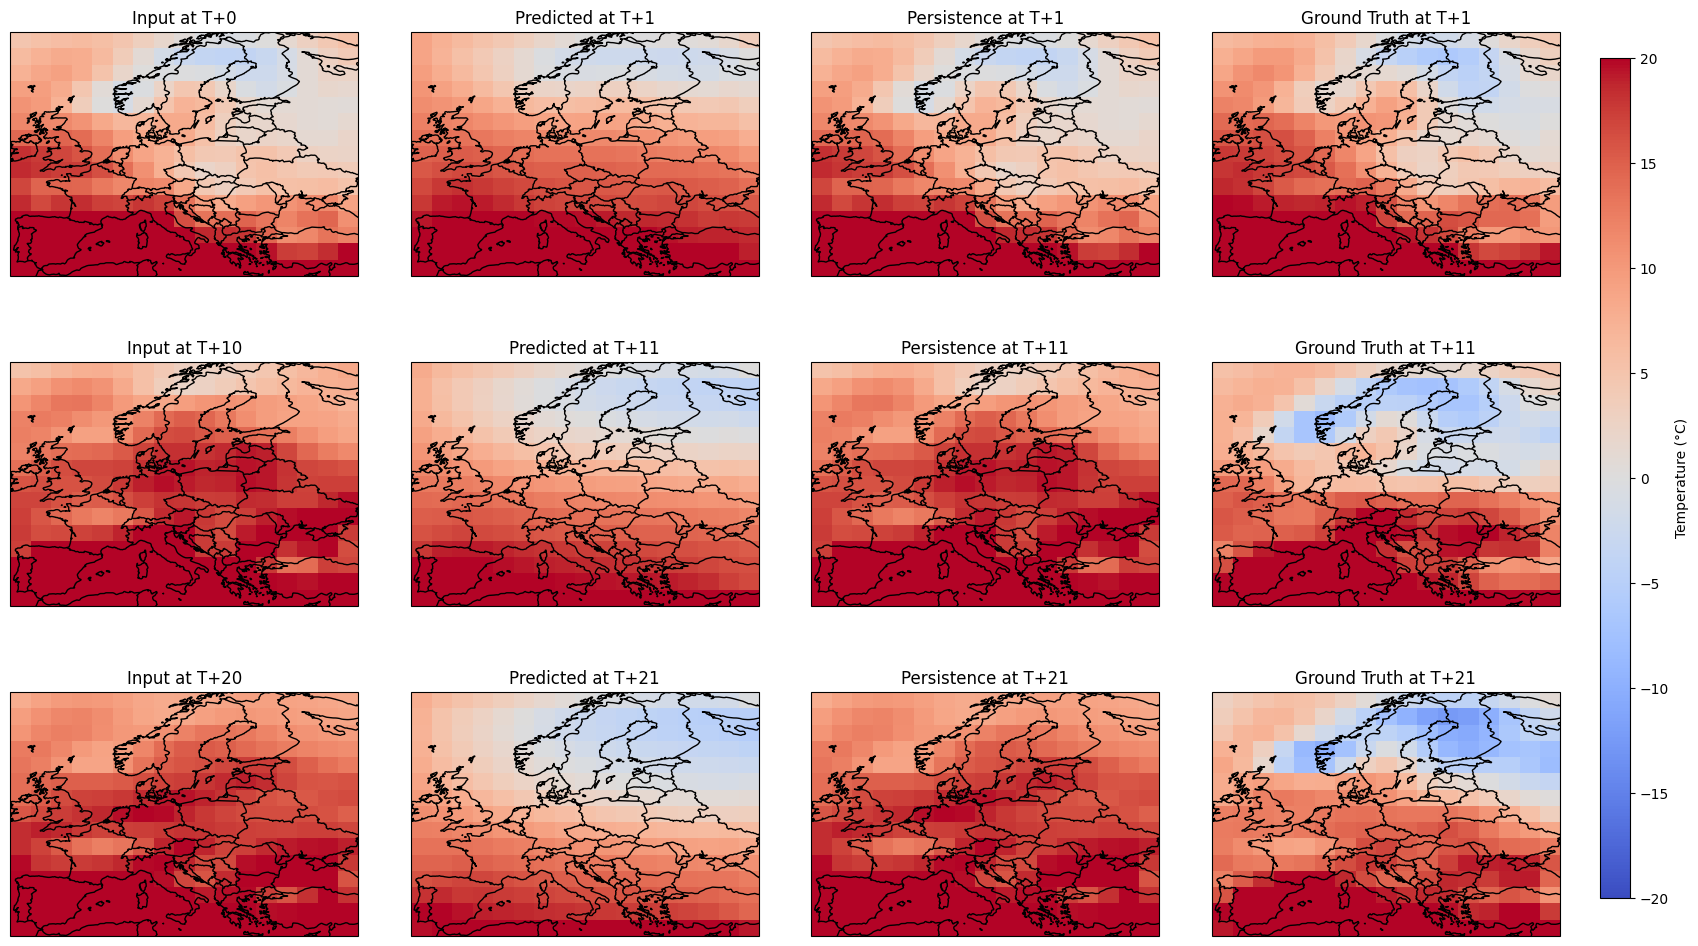

In [13]:
BATCH_IDX = 0
pred_indices = [0, 10, 20]  # prediction steps relative to last input (T+1, T+3, T+5)

# De-normalize the data
x_C = x[BATCH_IDX].cpu() * std + mean       # (seq_len, H, W)
y_pred_C = y_pred[BATCH_IDX].cpu() * std + mean  # (pred_len, H, W)
y_true_C = y_true[BATCH_IDX].cpu() * std + mean  # (pred_len, H, W)

# Convert from Kelvin to Celsius
x_C -= 273.15
y_pred_C -= 273.15
y_true_C -= 273.15

# Set realistic temperature limits for January
vmin = -20
vmax = 20

# Create figure
fig, axes = plt.subplots(len(pred_indices), 4, figsize=(20, 4*len(pred_indices)),
                         subplot_kw={'projection': ccrs.PlateCarree()})

for i, t in enumerate(pred_indices):

    # Plot Input
    ax = axes[i,0]
    im = ax.imshow(x_C[t-1], cmap='coolwarm', vmin=vmin, vmax=vmax,
                   extent=[lon_min, lon_max, lat_min, lat_max],
                   origin='upper')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_title(f"Input at T+{t}")

    # Plot Predicted
    ax = axes[i,1]
    im = ax.imshow(y_pred_C[t], cmap='coolwarm', vmin=vmin, vmax=vmax,
                   extent=[lon_min, lon_max, lat_min, lat_max],
                   origin='upper')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_title(f"Predicted at T+{t+1}")

    # Plot Persistence
    ax = axes[i,2]
    im = ax.imshow(x_C[t-1], cmap='coolwarm', vmin=vmin, vmax=vmax,
                   extent=[lon_min, lon_max, lat_min, lat_max],
                   origin='upper')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_title(f"Persistence at T+{t+1}")

    # Plot Ground Truth
    ax = axes[i,3]
    im = ax.imshow(y_true_C[t], cmap='coolwarm', vmin=vmin, vmax=vmax,
                   extent=[lon_min, lon_max, lat_min, lat_max],
                   origin='upper')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_title(f"Ground Truth at T+{t+1}")

# Add single colorbar (axe dédié)
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Temperature (°C)")

# Ajuster l'espace pour laisser la place à la colorbar
plt.subplots_adjust(right=0.9, wspace=0.15, hspace=0.25)

plt.show()
plt.show()

### Interpretation

The deep learning model preserves the large-scale spatial structures
of the meteorological field, such as smooth gradients and coherent patterns

Errors are not uniformly distributed in space. They tend to be larger in regions with strong gradients or rapid local changes. This highlights the difficulty of modeling small-scale, fast-evolving phenomena using purely data-driven approaches.

In contrast, the persistence baseline fails to account for the
temporal evolution of these structures and systematically underestimates
their displacement and deformation. 

## Conclusion and possible extensions

This demo illustrates how deep learning models can be applied to spatio-temporal weather forecasting. The observed behavior is consistent with the findings of the reference paper, which shows that data-driven models can capture large-scale atmospheric dynamics but still struggle with long-term stability and fine-scale variability.

Although the model improves over persistence, it remains a deterministic predictor.
It does not provide uncertainty estimates, which are crucial in operational forecasting.

Moreover, the model is trained on a limited temporal window, which may limit its ability to generalize to rare or extreme events.

Possible extensions include:
- predicting uncertainty instead of point estimates,
- using multi-variable inputs (temperature, wind, pressure),
- testing alternative architectures (Transformers, Graph Neural Networks),
- evaluating generalization to extreme events.

These directions are directly connected to current research
in data-driven weather prediction such as Pangu-Weather that pushes this concept further with 3D Transformers on a global scale.


### ConvLSTM vs. modern weather Transformers (e.g. Pangu-Weather)

Recent state-of-the-art weather models such as **Pangu-Weather** rely on **Transformer-based architectures** operating on 3D atmospheric fields (longitude, latitude, pressure levels).

Key differences:
- Pangu-Weather uses **global self-attention**, while ConvLSTM relies on local convolutions
- Pangu-Weather models **multi-scale and long-range dependencies**
- Pangu-Weather introduces **Hierarchical Temporal Aggregation (HTA)** to stabilize
  long-term forecasts and reduce error accumulation (which are limitations of ConvLSTM)

ConvLSTM doesn't include an HTA mechanism. Its temporal modeling is entirely handled by the recurrent structure itself, which makes it simpler but also more limited for long-range forecasting.


ConvLSTM can be seen as a **precursor to modern spatio-temporal weather models**: it provides a clear and interpretable way to combine spatial structure and temporal dynamics, making it an excellent baseline and pedagogical tool before introducing large-scale Transformer-based architectures such as Pangu-Weather.